# Experiment 3

This is a rewrite of earlier experiments, using wordcounts instead of raw quote counts. Like Experiment 2, it uses data from the rewritten text matcher. 

In [1]:
import spacy
import pandas as pd
%matplotlib inline
from ast import literal_eval
import numpy as np
import re
import json
from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [2]:
nlp = spacy.load('en')

In [3]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [4]:
textALength = len(mm) 

In [5]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [6]:
with open('../txt/e2a.json') as f: 
    rawData = f.read()

In [7]:
df = pd.read_json(rawData)

In [11]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

In [12]:
sum([len(item) for item in df['Locations in A'].values])

1794

In [73]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [78]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [129]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=50): 
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts
        else: 
            decadeDict[decade] += locationsAndWordcounts
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    decadesBinned = {decade: 
                 np.histogram([loc[0] for loc in locations], 
                              bins=bins,
                              weights=[loc[1] for loc in locations],
                              range=(0, textALength))[0]
                 for decade, locations in decadeStartsWeights.items() 
                     if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    doc = nlp(mm[locRange[0]:locRange[1]], tag=False, parse=False, entity=False)
    return len(doc)

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def synchronicAnalysis(df, bins=50): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    binned = np.histogram(starts, bins=bins, 
                          weights=counts, range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
#     plt.title("Frequency of Quotations from George Eliot's Middlemarch in Criticism, By Decade")
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    plt.show()
    
def plotSynchronicAnalysis(s): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Words Quoted')

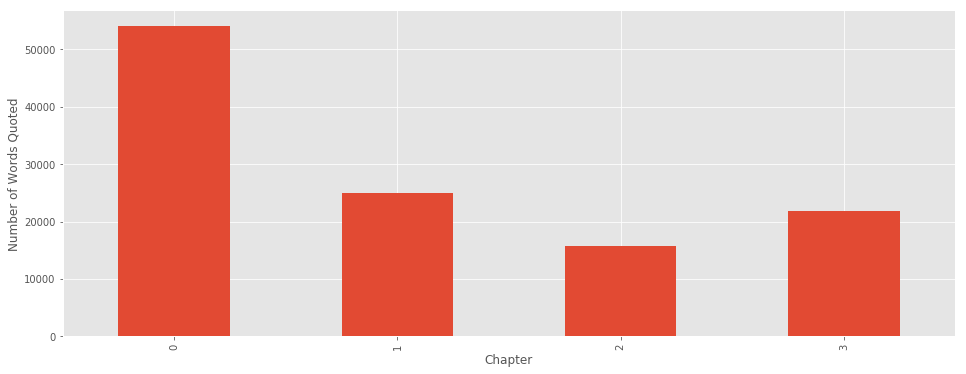

In [130]:
plotSynchronicAnalysis(synchronicAnalysis(df, bins=4))

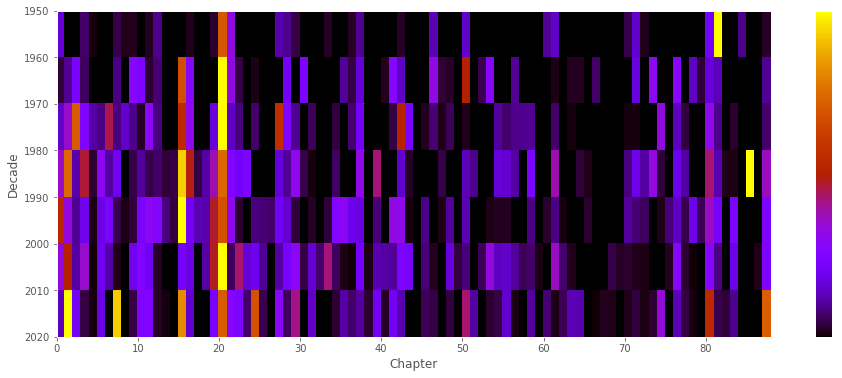

In [131]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations))

# By (Guessed) Gender of Author

In [106]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

In [107]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [108]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

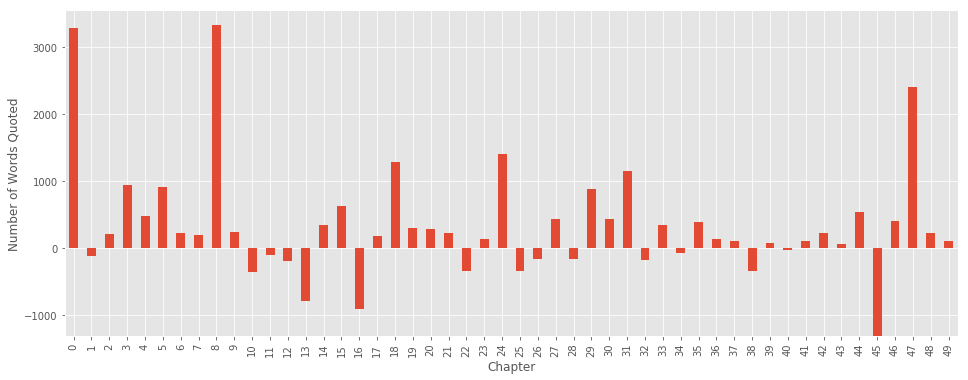

In [109]:
# Differences in citations between genders. 
plotSynchronicAnalysis(synchronicAnalysis(dfM) - synchronicAnalysis(dfF))

# By (Guessed) Country of Publication

In [110]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [111]:
publishers = topPublishers[:80].index

In [112]:
publishers = publishers.tolist()

In [113]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [114]:
df['country'] = df['publisher_name'].apply(getCountry)

In [115]:
df['country'].value_counts()

US         3901
Unknown    1247
Britain     825
Canada       59
Germany      15
Spain         8
Ireland       8
France        6
Name: country, dtype: int64

In [116]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [117]:
# Since British authors are greatly outnumbered in this corpus, we should normalize the data. 
britsHist = synchronicAnalysis(dfBrits) 
normBrits = britsHist.div(britsHist.max())
yanksHist = synchronicAnalysis(dfYanks)
normYanks = yanksHist.div(yanksHist.max())

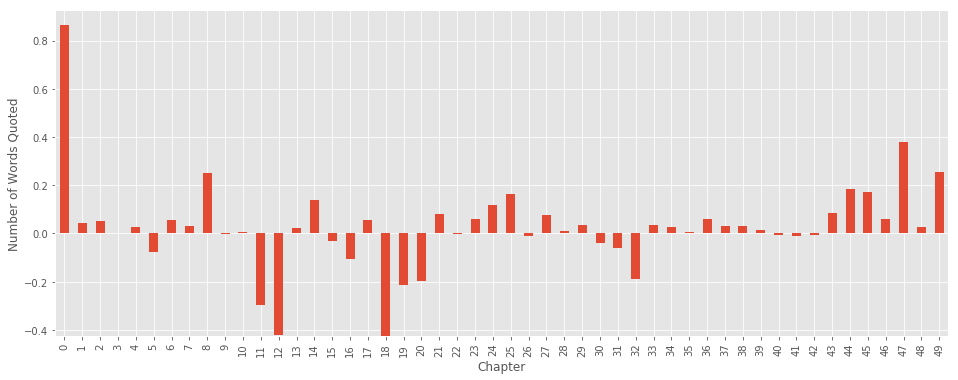

In [118]:
plotSynchronicAnalysis(normYanks - normBrits)

# By Journal

In [119]:
# Look at the top journals. 
df['journal'].value_counts()[:10]

Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
Nineteenth-Century Literature                126
NOVEL: A Forum on Fiction                    126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [120]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [121]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

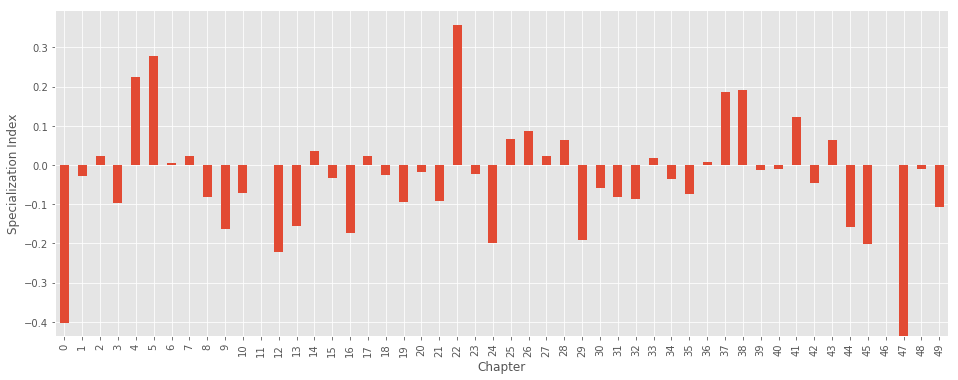

In [122]:
ax = (normGE - normOther).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')

# Detour: Ch. 15

In [123]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 322051: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [124]:
# Get the titles of those articles. 
[item.title for item in chap15s]

[['Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"'],
 ['"Middlemarch" and George Eliot\'s Female (Re) Vision of Shakespeare'],
 ['Heroism and Organicism in the Case of Lydgate'],
 ['THE DIALOGIC UNIVERSE OF "MIDDLEMARCH"'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['Microscopy and Semiotic in Middlemarch'],
 ["George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch"],
 ["The Victorian Discourse of Gambling: Speculations on Middlemarch and the Duke's Children"],
 ['George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"'],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ["The Turn of George Eliot's Realism"],
 ['Transformation of Rage',
  "Mourning and Creativity in George Eliot's Fiction",
  'The Vast Wreck of Ambitious Ideals in Middlemarch'],
 ['SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"'],
 ['Heroic Commitment in Richardson, Eliot, and Jam

In [125]:
ch15Topics =  [item.topics for item in chap15s]
chap15TopicsFlat = [item for sublist in ch15Topics for item in sublist]
Counter(chap15TopicsFlat).most_common(20)

[('Vocation', 8),
 ('Love', 8),
 ('Pity', 8),
 ('Novelists', 8),
 ('Gossip', 6),
 ('Sympathy', 6),
 ('Irony', 6),
 ('Narratology', 5),
 ('Novels', 5),
 ('Humor', 4),
 ('Heroism', 4),
 ('Vanity', 4),
 ('Marriage ceremonies', 4),
 ('Melodrama', 4),
 ('Gambling', 4),
 ('Antitheses', 4),
 ('Pathos', 4),
 ('Objectivity', 3),
 ('Compassion', 3),
 ('Armchairs', 3)]